# Pragmatic color describers

In [ ]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2022"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [The corpus](#The-corpus)
    1. [Corpus reader](#Corpus-reader)
    1. [ColorsCorpusExample instances](#ColorsCorpusExample-instances)
    1. [Far, Split, and Close conditions](#Far,-Split,-and-Close-conditions)
1. [Toy problems for development work](#Toy-problems-for-development-work)
1. [Core model](#Core-model)
    1. [Toy dataset illustration](#Toy-dataset-illustration)
    1. [Predicting sequences](#Predicting-sequences)
    1. [Listener-based evaluation](#Listener-based-evaluation)
    1. [BLEU scores](#BLEU-scores)
    1. [Other prediction and evaluation methods](#Other-prediction-and-evaluation-methods)
    1. [Cross-validation](#Cross-validation)
1. [Baseline SCC model](#Baseline-SCC-model)
1. [Modifying the core model](#Modifying-the-core-model)
    1. [Illustration: LSTM Cells](#Illustration:-LSTM-Cells)
    1. [Illustration: Deeper models](#Illustration:-Deeper-models)

## Overview

This notebook is part of our unit on grounding. It illustrates core concepts from the unit, and it provides useful background material for the associated homework and bake-off.

## Set-up

In [ ]:
from colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch_color_describer import (
    ContextualColorDescriber, create_example_dataset)
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [ ]:
utils.fix_random_seeds()

The [Stanford English Colors in Context corpus](https://cocolab.stanford.edu/datasets/colors.html) (SCC) is included in the data distribution for this course. If you store the data in a non-standard place, you'll need to update the following:

In [ ]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## The corpus

The SCC corpus is based in a two-player interactive game. The two players share a context consisting of three color patches, with the display order randomized between them so that they can't use positional information when communicating.

The __speaker__ is privately assigned a target color and asked to produce a description of it that will enable the __listener__ to identify the speaker's target. The listener makes a choice based on the speaker's message, and the two  succeed if and only if the listener identifies the target correctly.

In the game, the two players played repeated reference games and could communicate with each other in a free-form way. This opens up the possibility of modeling these repeated interactions as task-oriented dialogues. However, for this unit, we'll ignore most of this structure. We'll treat the corpus as a bunch of independent reference games played by anonymous players, and we will ignore the listener and their choices entirely.

For the bake-off, we will be distributing a separate test set. Thus, all of the data in the SCC can be used for exploration and development.

### Corpus reader

The corpus reader class is `ColorsCorpusReader` in `colors.py`. The reader's primary function is to let you iterate over corpus examples:

In [ ]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True)

The two keyword arguments have their default values here. 

* If you supply `word_count` with an interger value, it will restrict to just examples where the utterance has that number of words (using a whitespace heuristic). This creates smaller corpora that are useful for development.

* The colors in the corpus are in [HLS format](https://en.wikipedia.org/wiki/HSL_and_HSV). With `normalize_colors=False`, the first (hue) value is an integer between 1 and 360 inclusive, and the L (lightness) and S (saturation) values are between 1 and 100 inclusive. With `normalize_colors=True`, these values are all scaled to between 0 and 1 inclusive. The default is `normalize_colors=True` because this is a better choice for all the machine learning models we'll consider.

In [ ]:
examples = list(corpus.read())

We can verify that we read in the same number of examples as reported in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142):

In [ ]:
# Should be 46994:

len(examples)

46994

### ColorsCorpusExample instances

The examples are `ColorsCorpusExample` instances:

In [ ]:
ex1 = next(corpus.read())

These objects have a lot of attributes and methods designed to help you study the corpus and use it for our machine learning tasks. Let's review some highlights.

#### Displaying examples

You can see what the speaker saw, with the utterance they chose printed above the patches:

The darker blue one


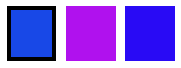

In [ ]:
ex1.display(typ='speaker')

This is the original order of patches for the speaker. The target happens to be the leftmost patch, as indicated by the black box around it.

Here's what the listener saw, with the speaker's message printed above the patches:

The darker blue one


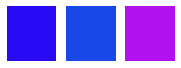

In [ ]:
ex1.display(typ='listener')

The listener isn't shown the target, of course, so no patches are highlighted.

If `display` is called with no arguments, then the target is placed in the final position and the other two are given in an order determined by the corpus metadata:

The darker blue one


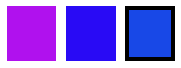

In [ ]:
ex1.display()

This is the representation order we use for our machine learning models.

#### Color representations

For machine learning, we'll often need to access the color representations directly. The primary attribute for this is `colors`:

In [ ]:
ex1.colors

[[0.7861111111111111, 0.5, 0.87],
 [0.6888888888888889, 0.5, 0.92],
 [0.6277777777777778, 0.5, 0.81]]

In this display order, the third element is the target color and the first two are the distractors. The attributes `speaker_context` and `listener_context` return the same colors but in the order that those players saw them. For example:

In [ ]:
ex1.speaker_context

[[0.6277777777777778, 0.5, 0.81],
 [0.7861111111111111, 0.5, 0.87],
 [0.6888888888888889, 0.5, 0.92]]

#### Utterance texts

Utterances are just strings: 

In [ ]:
ex1.contents

'The darker blue one'

There are cases where the speaker made a sequences of utterances for the same trial. We follow [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) in concatenating these into a single utterance. To preserve the original information, the individual turns are separated by `" ### "`. Example 3 is the first with this property – let's check it out:

In [ ]:
ex3 = examples[2]

In [ ]:
ex3.contents

'Medium pink ### the medium dark one'

The method `parse_turns` will parse this into individual turns:

In [ ]:
ex3.parse_turns()

['Medium pink', 'the medium dark one']

For examples consisting of a single turn, `parse_turns` returns a list of length 1:

In [ ]:
ex1.parse_turns()

['The darker blue one']

### Far, Split, and Close conditions

The SCC contains three conditions:
    
__Far condition__: All three colors are far apart in color space.  Example:

Condition type: far
purple


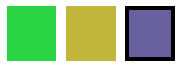

In [ ]:
print("Condition type:", examples[1].condition)

examples[1].display()

__Split condition__: The target is close to one of the distractors, and the other is far away from both of them. Example:

Condition type: split
lime


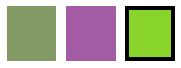

In [ ]:
print("Condition type:", examples[3].condition)

examples[3].display()

__Close condition__: The target is similar to both distractors. Example:

Condition type: close
Medium pink ### the medium dark one


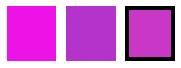

In [ ]:
print("Condition type:", examples[2].condition)

examples[2].display()

These conditions go from easiest to hardest when it comes to reliable communication. In the __Far__ condition, the context is hardly relevant, whereas the nature of the distractors reliably shapes the speaker's choices in the other two conditions. 

You can begin to see how this affects speaker choices in the above examples: "purple" suffices for the __Far__ condition, a more marked single word ("lime") is used in the __Split__ condition, and the __Close__ condition triggers a pretty long, complex description.

The `condition` attribute provides access to this value: 

In [ ]:
ex1.condition

'close'

The following verifies that we have the same number of examples per condition as reported in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142):

In [ ]:
pd.Series([ex.condition for ex in examples]).value_counts()

far      15782
split    15693
close    15519
dtype: int64

## Toy problems for development work

The SCC corpus is fairly large and quite challenging as an NLU task. This means it isn't ideal when it comes to testing hypotheses and debugging code. Poor performance could trace to a mistake, but it could just as easily trace to the fact that the problem is very challenging from the point of view of optimization.

To address this, the module `torch_color_describer.py` includes a function `create_example_dataset` for creating small, easy datasets with the same basic properties as the SCC corpus.

Here's a toy problem containing just six examples:

In [ ]:
tiny_contexts, tiny_words, tiny_vocab = create_example_dataset(
    group_size=2, vec_dim=2)

In [ ]:
tiny_vocab

['<s>', '</s>', 'A', 'B', '$UNK']

In [ ]:
tiny_words

[['<s>', 'A', '</s>'],
 ['<s>', 'A', '</s>'],
 ['<s>', 'A', 'B', '</s>'],
 ['<s>', 'A', 'B', '</s>'],
 ['<s>', 'B', 'A', 'B', 'A', '</s>'],
 ['<s>', 'B', 'A', 'B', 'A', '</s>']]

In [ ]:
tiny_contexts

[[array([0.84464215, 0.94729424]),
  array([0.5353399 , 0.57843591]),
  array([0.00500215, 0.05500586])],
 [array([0.80595944, 0.84372759]),
  array([0.50107106, 0.40530719]),
  array([0.01738777, 0.08438436])],
 [array([0.88390396, 0.88984181]),
  array([0.05563814, 0.17386006]),
  array([0.54320392, 0.54026499])],
 [array([0.88452288, 0.85557427]),
  array([0.04306275, 0.15269883]),
  array([0.55176147, 0.43193186])],
 [array([0.56949887, 0.52074521]),
  array([0.16142565, 0.14594636]),
  array([0.81854917, 0.81934328])],
 [array([0.47570688, 0.51040813]),
  array([0.16588093, 0.12370395]),
  array([0.90724562, 0.99462315])]]

Each member of `tiny_contexts` contains three vectors. This is meant to be an easy problem, so the final (target) vector always has values that unambiguously determine which utterance is produced. Thus, the model basically just needs to learn to ignore the distractors and find the association between the target vector and the corresponding sequence. 

All the models we study have a capacity to solve this task with very little data, so you should see perfect or near perfect performance on reasonably-sized versions of this task.

## Core model

Our core model for this problem is implemented in `torch_color_describer.py` as `ContextualColorDescriber`. At its heart, this is a pretty standard encoder–decoder model:

* `Encoder`: Processes the color contexts as a sequence. We always place the target in final position so that it is closest to the supervision signals that we get when decoding.

* `Decoder`: A neural language model whose initial hidden representation is the final hidden representation of the `Encoder`.

* `EncoderDecoder`: Coordinates the operations of the `Encoder` and `Decoder`.

Finally, `ContextualColorDescriber` is a wrapper around these model components. It handles the details of training and implements the prediction and evaluation functions that we will use.

Many additional details about this model are included in the slides for this unit.

### Toy dataset illustration

To highlight the core functionality of `ContextualColorDescriber`, let's create a small toy dataset and use it to train and evaluate a model:

In [ ]:
toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
    group_size=50, vec_dim=2)

In [ ]:
toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
    train_test_split(toy_color_seqs, toy_word_seqs)

`ContextualColorDescriber` is a subclass of `TorchModelBase`, so all of the optimization parameters from that model are available here; see [torch_model_base.py](torch_model_base.py) for full details.

Here is a simple use of `ContextualColorDescriber`:

In [ ]:
toy_mod = ContextualColorDescriber(toy_vocab, max_iter=200)

In [ ]:
_ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

Finished epoch 200 of 200; error is 0.26593607664108276

### Predicting sequences

The `predict` method takes a list of color contexts as input and returns model descriptions:

In [ ]:
toy_preds = toy_mod.predict(toy_color_seqs_test)

In [ ]:
toy_preds[0]

['<s>', 'A', 'B', '</s>']

We can then check that we predicted all correct sequences:

In [ ]:
toy_correct = sum(1 for x, p in zip(toy_word_seqs_test, toy_preds) if x == p)

toy_correct / len(toy_word_seqs_test)

1.0

For real problems, this is too stringent a requirement, since there are generally many equally good descriptions. This insight gives rise to metrics like [BLEU](https://en.wikipedia.org/wiki/BLEU), [METEOR](https://en.wikipedia.org/wiki/METEOR), [ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric)), [CIDEr](https://arxiv.org/pdf/1411.5726.pdf), and others, which seek to relax the requirement of an exact match with the test sequence. These are reasonable options to explore, but we will instead adopt a communcation-based evaluation, as discussed in the next section.

### Listener-based evaluation

`ContextualColorDescriber` implements a method `listener_accuracy` that we will use for our primary evaluations in the assignment and bake-off. The essence of the method is that we can calculate

$$
c^{*} = \text{argmax}_{c \in C} P_S(\text{utterance} \mid c)
$$


where $P_S$ is our describer model and $C$ is the set of all permutations of all three colors in the color context. We take $c^{*}$ to be a correct prediction if it is one where the target is in the privileged final position. (There are two such contexts; we try both in case the order of the distractors influences the predictions, and the model is correct if one of them has the highest probability.)

Here's the listener accuracy of our toy model:

In [ ]:
toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

1.0

### BLEU scores

The listener-based evaluation scheme has the unusual property that, in some sense, it assesses the model's ability to communicate with itself. This creates a danger that it will drift far from English as we know it but still succeed in signaling the target color. Ideally, we would train a separate listener model to help prevent this, but doing so would be cumbersome and could limit creative system development. Thus, as a quick check that our systems are still going to be able to communicate with us, we can calculate a BLEU score:

In [ ]:
bleu_score, predicted_texts = toy_mod.corpus_bleu(toy_color_seqs_test, toy_word_seqs_test)

bleu_score

1.0

For discussion of BLEU scores, see the [evaluation metrics notebook](evaluation_metrics.ipynb).

### Other prediction and evaluation methods

You can get the perplexities for test examples with `perplexities`:

In [ ]:
toy_perp = toy_mod.perplexities(toy_color_seqs_test, toy_word_seqs_test)

In [ ]:
toy_perp[0]

1.0132557330997753

You can use `predict_proba` to see the full probability distributions assigned to test examples:

In [ ]:
toy_proba = toy_mod.predict_proba(toy_color_seqs_test, toy_word_seqs_test)

In [ ]:
# 4 tokens, each assigned a distribution over 5 vocab items:

print(toy_word_seqs_test[0])

toy_proba[0].shape

['<s>', 'A', 'B', '</s>']


(4, 5)

In [ ]:
for timestep in toy_proba[0]:
    print(dict(zip(toy_vocab, timestep)))

{'<s>': 1.0, '</s>': 0.0, 'A': 0.0, 'B': 0.0, '$UNK': 0.0}
{'<s>': 0.00018379976, '</s>': 0.00022975517, 'A': 0.9946944, 'B': 0.004481194, '$UNK': 0.00041091096}
{'<s>': 0.0010102493, '</s>': 0.02337423, 'A': 0.0016727175, 'B': 0.9730926, '$UNK': 0.00085018104}
{'<s>': 0.0046478347, '</s>': 0.9801214, 'A': 0.01115099, 'B': 0.0027307996, '$UNK': 0.001349019}


### Cross-validation

You can use `utils.fit_classifier_with_hyperparameter_search` to cross-validate these models. Just be sure to set `scoring=None` so that the sklearn model selection methods use the `score` method of `ContextualColorDescriber`, which is an alias for `listener_accuracy`:

In [ ]:
best_mod = utils.fit_classifier_with_hyperparameter_search(
    toy_color_seqs_train,
    toy_word_seqs_train,
    toy_mod,
    cv=2,
    scoring=None,
    param_grid={'hidden_dim': [10, 20]})

/Applications/anaconda3/envs/nlu/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Finished epoch 200 of 200; error is 0.45002618432044983

Best params: {'hidden_dim': 20}
Best score: 1.000


## Baseline SCC model

Just to show how all the pieces come together, here's a very basic SCC experiment using the core code and very simplistic assumptions (which you will revisit in the assignment) about how to represent the examples:

To facilitate quick development, we'll restrict attention to the two-word examples:

In [ ]:
dev_corpus = ColorsCorpusReader(COLORS_SRC_FILENAME, word_count=2)

In [ ]:
dev_examples = list(dev_corpus.read())

In [ ]:
len(dev_examples)

13890

Here we extract the raw colors and texts (as strings):

In [ ]:
dev_cols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

To tokenize the examples, we'll just split on whitespace, taking care to add the required boundary symbols:

In [ ]:
dev_word_seqs = [[START_SYMBOL] + text.split() + [END_SYMBOL] for text in dev_texts]

We'll use a random train–test split:

In [ ]:
dev_cols_train, dev_cols_test, dev_word_seqs_train, dev_word_seqs_test = \
    train_test_split(dev_cols, dev_word_seqs)

Our vocab is determined by the train set, and we take care to include the `$UNK` token:

In [ ]:
dev_vocab = sorted({w for toks in dev_word_seqs_train for w in toks})

dev_vocab += [UNK_SYMBOL]

And now we're ready to train a model:

In [ ]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    embed_dim=10,
    hidden_dim=10,
    early_stopping=True)

In [ ]:
%time _ = dev_mod.fit(dev_cols_train, dev_word_seqs_train)

Stopping after epoch 17. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 57.85624027252197

CPU times: user 1min 50s, sys: 5.29 s, total: 1min 55s
Wall time: 56.9 s


And finally an evaluation in terms of listener accuracy and BLEU scores. The `evaluate` method combines these:

In [ ]:
dev_mod_eval = dev_mod.evaluate(dev_cols_test, dev_word_seqs_test)

In [ ]:
dev_mod_eval['listener_accuracy']

0.367117765620501

In [ ]:
dev_mod_eval['corpus_bleu']

0.05830693924560899

## Modifying the core model

The first few assignment problems concern how you preprocess the data for your model. After that, the goal is to subclass model components in `torch_color_describer.py`. For the bake-off submission, you can do whatever you like in terms of modeling, but my hope is that you'll be able to continue subclassing based on `torch_color_describer.py`.

This section provides some illustrative examples designed to give you a feel for how the code is structured and what your options are in terms of creating subclasses. The principles are the same as those reviewed for a wider range of models in [tutorial_pytorch_models.ipynb](tutorial_pytorch_models.ipynb).

### Illustration: LSTM Cells

Both the `Encoder` and the `Decoder` of `torch_color_describer` are currently GRU cells. Switching to another cell type is easy:

__Step 1__: Subclass the `Encoder`; all we have to do here is change `GRU` from the original to `LSTM`:

In [ ]:
import torch.nn as nn
from torch_color_describer import Encoder

class LSTMEncoder(Encoder):
    def __init__(self, color_dim, hidden_dim):
        super().__init__(color_dim, hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)

__Step 2__: Subclass the `Decoder`, making the same simple change as above:

In [ ]:
import torch.nn as nn
from torch_color_describer import Encoder, Decoder

class LSTMDecoder(Decoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)

__Step 3__:`ContextualColorDescriber` has a method called `build_graph` that sets up the `Encoder` and `Decoder`. The needed revision just uses `LSTMEncoder`:

In [ ]:
from torch_color_describer import EncoderDecoder

class LSTMContextualColorDescriber(ContextualColorDescriber):

    def build_graph(self):

        # Use the new Encoder:
        encoder = LSTMEncoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use the new Decoder:
        decoder = LSTMDecoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim)

        return EncoderDecoder(encoder, decoder)

Here's an example run:

In [ ]:
lstm_mod = LSTMContextualColorDescriber(
    toy_vocab,
    embed_dim=10,
    hidden_dim=10)

In [ ]:
_ = lstm_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

Finished epoch 1000 of 1000; error is 0.12768782675266266

In [ ]:
lstm_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

1.0

### Illustration: Deeper models

The `Encoder` and `Decoder` are both currently hard-coded to have just one hidden layer. It is straightforward to make them deeper as long as we ensure that both the `Encoder` and `Decoder` have the same depth; since the `Encoder` final states are the initial hidden states for the `Decoder`, we need this alignment. 

(Strictly speaking, we could have different numbers of `Encoder` and `Decoder` layers, as long as we did some kind of averaging or copying to achieve the hand-off from `Encoder` to `Decoder`. I'll set this possibility aside.)

__Step 1__: We need to subclass the `Encoder` and `Decoder` so that they have `num_layers` argument that is fed into the RNN cell:

In [ ]:
import torch.nn as nn
from torch_color_describer import Encoder, Decoder

class DeepEncoder(Encoder):
    def __init__(self, *args, num_layers=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_layers = num_layers
        self.rnn = nn.GRU(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True)


class DeepDecoder(Decoder):
    def __init__(self, *args, num_layers=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_layers = num_layers
        self.rnn = nn.GRU(
            input_size=self.embed_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True)

__Step 2__: As before, we need to update the `build_graph` method of `ContextualColorDescriber`. The needed revision just uses `DeepEncoder` and `DeepDecoder`. To expose this new argument to the user, we also add a new keyword argument to `ContextualColorDescriber`:

In [ ]:
from torch_color_describer import EncoderDecoder

class DeepContextualColorDescriber(ContextualColorDescriber):
    def __init__(self, *args, num_layers=2, **kwargs):
        self.num_layers = num_layers
        super().__init__(*args, **kwargs)

    def build_graph(self):
        encoder = DeepEncoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers)  # The new piece is this argument.

        decoder = DeepDecoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers)  # The new piece is this argument.

        return EncoderDecoder(encoder, decoder)

An example/test run:

In [ ]:
mod_deep = DeepContextualColorDescriber(
    toy_vocab,
    embed_dim=10,
    hidden_dim=10)

In [ ]:
_ = mod_deep.fit(toy_color_seqs_train, toy_word_seqs_train)

Finished epoch 1000 of 1000; error is 0.1362161487340927

In [ ]:
mod_deep.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

1.0